In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))

from NeuralNet import NeuralNet

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (19237, 18)
Test shape: (8245, 18)


In [3]:
numeric_object_cols = ['Engine volume','Mileage','Levy']

for col in numeric_object_cols:
    # Eliminar caracteres que no sean dígitos o punto
    train[col] = train[col].replace(r'[^\d.]', '', regex=True)
    # Convertir a float, strings vacíos se vuelven NaN
    train[col] = pd.to_numeric(train[col], errors='coerce')

# Rellenar NaN con 0 (o puedes usar la media)
train[numeric_object_cols] = train[numeric_object_cols].fillna(0)

In [4]:
cat_cols = ['Levy','Manufacturer','Model','Category','Leather interior','Fuel type',
            'Gear box type','Drive wheels','Doors','Wheel','Color']

num_cols = ['Prod. year','Cylinders','Airbags','Engine volume','Mileage']

# Variable objetivo
y = train['Price'].values.reshape(-1,1)

In [5]:
# ===================== Normalize target =====================
y = train['Price'].values.reshape(-1,1).astype(float)
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X = preprocessor.fit_transform(train)

In [7]:
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X, y_norm = X[idx], y_norm[idx]

In [8]:
if hasattr(X, "toarray"):
    X = X.toarray()

input_size = X.shape[1]

# Definir red: 1 capa oculta de 20 neuronas, activación sigmoid
nn = NeuralNet(
    n_layers=3,
    n_units=[input_size, 20, 1],
    epochs=50,
    lr=0.001,
    momentum=0.8,
    activation='sigmoid',
    val_percent=0.2
)

nn.fit(X, y_norm)
y_pred_norm = nn.predict(X)
y_pred = y_pred_norm * y_std + y_mean

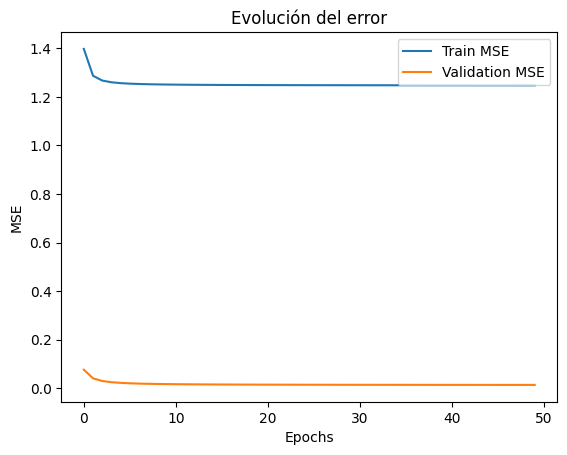

Errores por época (última fila = última epoch): [1.24735326 0.01348732]


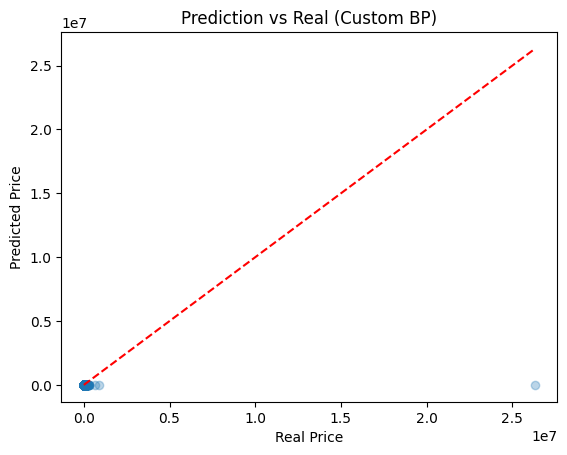

In [9]:
loss = nn.loss_epochs()
plt.plot(loss[:,0], label='Train MSE')
plt.plot(loss[:,1], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Evolución del error')
plt.legend()
plt.show()

print("Errores por época (última fila = última epoch):", loss[-1])

# ===================== Scatter plot: Predicted vs Real =====================
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # diagonal line y=x
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Prediction vs Real (Custom BP)')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def MAPE(y_true, y_pred):
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
param_grid = [
    {"layers": 3, "units": [input_size, 10, 1], "lr": 0.01, "momentum": 0.5, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 20, 1], "lr": 0.01, "momentum": 0.9, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 30, 1], "lr": 0.005, "momentum": 0.8, "act": "tanh"},
    {"layers": 3, "units": [input_size, 50, 1], "lr": 0.001, "momentum": 0.9, "act": "relu"},
    {"layers": 4, "units": [input_size, 32, 16, 1], "lr": 0.01, "momentum": 0.7, "act": "sigmoid"},
    {"layers": 4, "units": [input_size, 64, 32, 1], "lr": 0.005, "momentum": 0.8, "act": "tanh"},
    {"layers": 3, "units": [input_size, 16, 1], "lr": 0.02, "momentum": 0.5, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 40, 1], "lr": 0.002, "momentum": 0.9, "act": "tanh"},
    {"layers": 3, "units": [input_size, 25, 1], "lr": 0.01, "momentum": 0.9, "act": "relu"},
    {"layers": 4, "units": [input_size, 32, 16, 1], "lr": 0.001, "momentum": 0.8, "act": "linear"}
]

In [ ]:
results = []
best_mse = float('inf')
best_preds = None
best_params = None
best_loss_curve = None

for i, params in enumerate(param_grid):
    print(f"\n🔎 Training model {i+1}/{len(param_grid)} with params: {params}")

    nn = NeuralNet(
        n_layers=params["layers"],
        n_units=params["units"],
        epochs=50,
        lr=params["lr"],
        momentum=params["momentum"],
        activation=params["act"],
        val_percent=0.2
    )
    
    nn.fit(X, y_norm)

    # Loss curve
    loss_curve = nn.loss_epochs()

    # Predict (normalized)
    y_pred_norm = nn.predict(X)

    # Convert to original scale
    y_pred = y_pred_norm * y_std + y_mean

    # Metrics
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    
    # Save metrics
    results.append({
        "Layers": params["layers"],
        "Structure": str(params["units"]),
        "LR": params["lr"],
        "Momentum": params["momentum"],
        "Act": params["act"],
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "Loss": loss_curve       # <<--- 🔥 NECESARIO
    })

    # Save best model
    if mse < best_mse:
        best_mse = mse
        best_preds = y_pred
        best_params = params
        best_loss_curve = loss_curve  # <<--- 🔥 NECESARIO
    
    print(f" → MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("MSE").reset_index(drop=True)
df_results



🔎 Training model 1/10 with params: {'layers': 3, 'units': [2267, 10, 1], 'lr': 0.01, 'momentum': 0.5, 'act': 'sigmoid'}
 → MSE: 36331910812.97, MAE: 15520.15, MAPE: 2703.18%

🔎 Training model 2/10 with params: {'layers': 3, 'units': [2267, 20, 1], 'lr': 0.01, 'momentum': 0.9, 'act': 'sigmoid'}
 → MSE: 36319897841.44, MAE: 14377.81, MAPE: 2387.23%

🔎 Training model 3/10 with params: {'layers': 3, 'units': [2267, 30, 1], 'lr': 0.005, 'momentum': 0.8, 'act': 'tanh'}
 → MSE: 36579238014.83, MAE: 17627.52, MAPE: 2091.32%

🔎 Training model 4/10 with params: {'layers': 3, 'units': [2267, 50, 1], 'lr': 0.001, 'momentum': 0.9, 'act': 'relu'}
 → MSE: 36466110833.44, MAE: 16644.14, MAPE: 2735.63%

🔎 Training model 5/10 with params: {'layers': 4, 'units': [2267, 32, 16, 1], 'lr': 0.01, 'momentum': 0.7, 'act': 'sigmoid'}
 → MSE: 36323694989.06, MAE: 14823.80, MAPE: 2520.56%

🔎 Training model 6/10 with params: {'layers': 4, 'units': [2267, 64, 32, 1], 'lr': 0.005, 'momentum': 0.8, 'act': 'tanh'}
 →

,Layers,Structure,LR,Momentum,Act,MSE,MAE,MAPE,Loss
0,3,"[2267, 20, 1]",0.010,0.9,sigmoid,3.631990e+10,14377.812346,2387.231330,"[[0.018510108904282657, 4.953200113667811], [0..."
1,4,"[2267, 32, 16, 1]",0.010,0.7,sigmoid,3.632369e+10,14823.798799,2520.555833,"[[1.270624141034773, 0.015791381392971166], [1..."
2,3,"[2267, 16, 1]",0.020,0.5,sigmoid,3.632624e+10,15025.714779,2575.359198,"[[1.2875342923044508, 0.015930863525682015], [..."
3,3,"[2267, 10, 1]",0.010,0.5,sigmoid,3.633191e+10,15520.153701,2703.182989,"[[1.3136571081095045, 0.03304351472675671], [1..."
4,3,"[2267, 50, 1]",0.001,0.9,relu,3.646611e+10,16644.139538,2735.630735,"[[1.248419748723314, 0.008624067645371413], [1..."
5,3,"[2267, 25, 1]",0.010,0.9,relu,3.649313e+10,16830.769797,2758.390136,"[[1.2474640840450397, 0.010438614149022538], [..."
6,3,"[2267, 30, 1]",0.005,0.8,tanh,3.657924e+10,17627.515155,2091.317102,"[[1.2623700909211673, 0.01250000793425585], [1..."
7,3,"[2267, 40, 1]",0.002,0.9,tanh,3.659553e+10,17814.391613,2123.940251,"[[1.2674720447311056, 0.010934240115367212], [..."
8,4,"[2267, 64, 32, 1]",0.005,0.8,tanh,3.659935e+10,17607.299742,2109.582771,"[[1.3045604281703407, 0.026665618650344097], [..."
9,4,"[2267, 32, 16, 1]",0.001,0.8,linear,3.704777e+10,20855.253542,2438.819635,"[[1.255850456406299, 0.013436702146425497], [1..."


In [17]:
best_idx = df_results["MSE"].idxmin()
best_model = df_results.iloc[best_idx]
best_model


Layers                                                       3
Structure                                        [2267, 20, 1]
LR                                                        0.01
Momentum                                                   0.9
Act                                                    sigmoid
MSE                                         36319897841.442848
MAE                                               14377.812346
MAPE                                                2387.23133
Loss         [[0.018510108904282657, 4.953200113667811], [0...
Name: 0, dtype: object

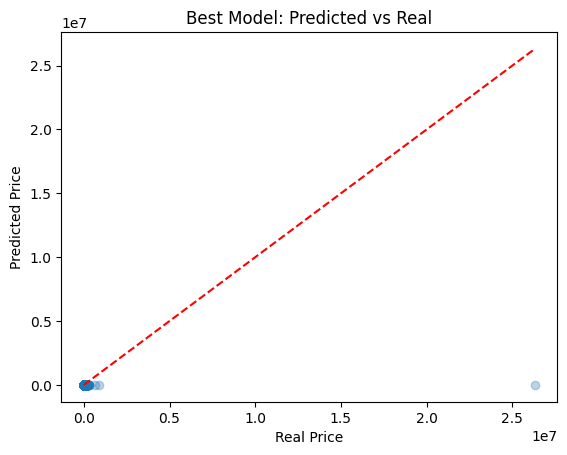

In [18]:
plt.scatter(y, best_preds, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.title("Best Model: Predicted vs Real")
plt.show()

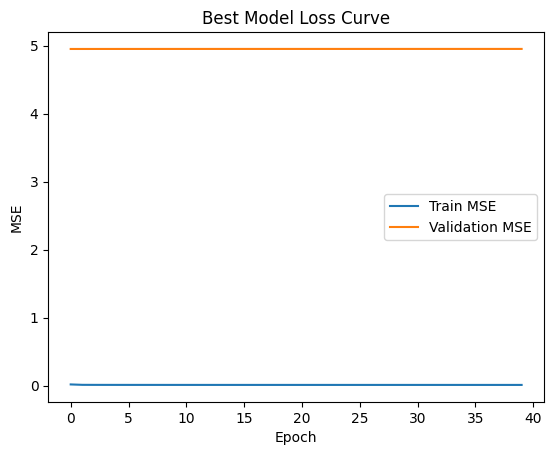

In [19]:
loss = best_loss_curve
plt.plot(loss[:,0], label='Train MSE')
plt.plot(loss[:,1], label='Validation MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Best Model Loss Curve")
plt.show()
